In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
import copy


In [3]:
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
adata.shape  # row is cells, column is gene

(161764, 33538)

In [4]:
type(adata.X)

scipy.sparse._csc.csc_matrix

In [4]:
# view adata.X
rows, cols = adata.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.4895154535770416
Row 0, Column 43, Value 0.8167138695716858
Row 0, Column 48, Value 0.8167138695716858
Row 0, Column 53, Value 0.8167138695716858
Row 0, Column 55, Value 1.424944519996643
Row 0, Column 66, Value 0.4895154535770416
Row 0, Column 77, Value 0.8167138695716858
Row 0, Column 78, Value 1.424944519996643
Row 0, Column 89, Value 0.8167138695716858
Row 0, Column 93, Value 1.0628387928009033
Row 0, Column 102, Value 0.8167138695716858
Row 0, Column 154, Value 2.4626553058624268
Row 0, Column 178, Value 0.8167138695716858
Row 0, Column 185, Value 0.4895154535770416
Row 0, Column 190, Value 0.4895154535770416
Row 0, Column 201, Value 1.8004224300384521
Row 0, Column 224, Value 0.8167138695716858
Row 0, Column 240, Value 0.4895154535770416
Row 0, Column 259, Value 0.4895154535770416
Row 0, Column 261, Value 1.566353440284729


In [5]:
all_zero_cols = adata.X.getnnz(axis=0) == 0
zero_cols_count = np.sum(all_zero_cols)
print('No. of columns with all zeros:', zero_cols_count)  # 6034


No. of columns with all zeros: 6034


In [6]:
# Remove columns with all zeros
adata = adata[:, ~all_zero_cols]
print('New shape of adata.X:', adata.X.shape)
print('New shape of adata.var:', adata.var.shape)

New shape of adata.X: (161764, 27504)
New shape of adata.var: (27504, 0)


In [7]:
# All level 1 celltypes
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(" ", "_")
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(" ", "_")
adata.obs['celltype.l3'] = adata.obs['celltype.l3'].str.replace(" ", "_")
types = np.unique(adata.obs['celltype.l2']).tolist()
print(types)
# cell count in each celltype
adata.obs['celltype.l2'].value_counts()

C:\Users\evanlee\AppData\Local\Temp\ipykernel_73552\2460788363.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(" ", "_")


['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


celltype.l2
CD14_Mono            42690
CD4_Naive            17479
NK                   17173
CD4_TCM              14889
CD8_TEM              11727
CD8_Naive            10768
B_naive               7718
CD16_Mono             6320
CD4_TEM               4282
gdT                   3649
B_memory              3285
CD8_TCM               2883
MAIT                  2784
Treg                  2507
cDC2                  2501
B_intermediate        2431
Platelet              2293
CD4_CTL               1736
NK_CD56bright          943
pDC                    861
Doublet                605
NK_Proliferating       548
Plasmablast            366
dnT                    356
HSPC                   329
cDC1                   151
ILC                    132
CD4_Proliferating      108
CD8_Proliferating       91
Eryth                   83
ASDC                    76
Name: count, dtype: int64

In [8]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## UMAP with stored embedding in Hao_PBMC_scaled_Harmony.h5ad

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

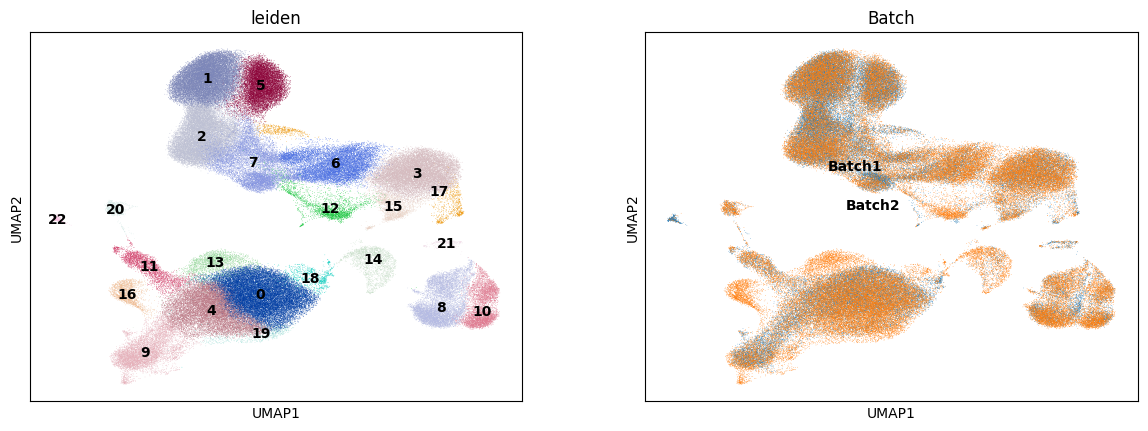

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

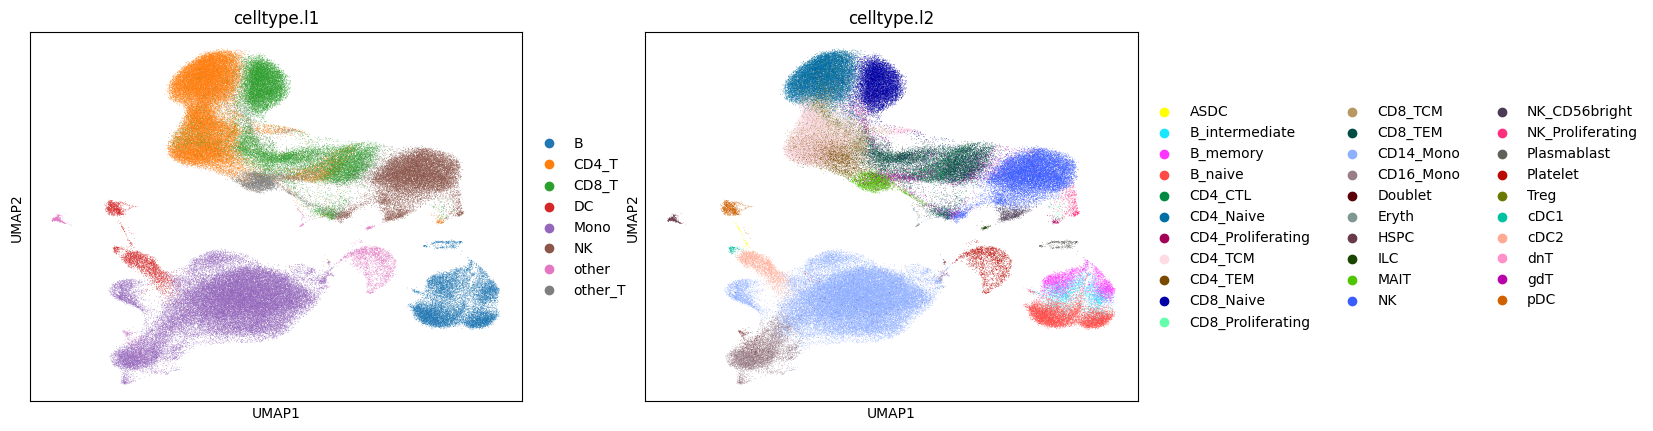

In [9]:
sc.pl.umap(adata, color=['leiden', 'Batch'], legend_loc="on data")
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'], legend_loc="right margin")

## Representative cells
Select top clustering coefficient cells in each cell type <br>
According to the inverse relationshiop between "celltype cell count" and "Percentage" <br>
Detailed in Excel file <br>

In [10]:
umap_adja_matrix = adata.obsp['connectivities']  # derived from sc.pp.neighbors()
umap_adja_matrix

<161764x161764 sparse matrix of type '<class 'numpy.float32'>'
	with 3703678 stored elements in Compressed Sparse Row format>

In [11]:
# Clustering coefficient
import networkx as nx

G = nx.from_scipy_sparse_array(umap_adja_matrix)
print(G)

clustering_coeff = nx.clustering(G)
print(len(clustering_coeff))

Graph with 161764 nodes and 1851839 edges
161764


In [12]:
# Get the first 10 keys and values of the dictionary
first_10_items = list(clustering_coeff.items())[:10]

# Print the first 10 keys and values
for key, value in first_10_items:
    print(f"Key: {key}, Value: {value}")

# Keys are cell index, values are the corresponding clustering coefficient

Key: 0, Value: 0.13157894736842105
Key: 1, Value: 0.1323529411764706
Key: 2, Value: 0.17582417582417584
Key: 3, Value: 0.10476190476190476
Key: 4, Value: 0.11052631578947368
Key: 5, Value: 0.17647058823529413
Key: 6, Value: 0.13333333333333333
Key: 7, Value: 0.13333333333333333
Key: 8, Value: 0.13725490196078433
Key: 9, Value: 0.09523809523809523


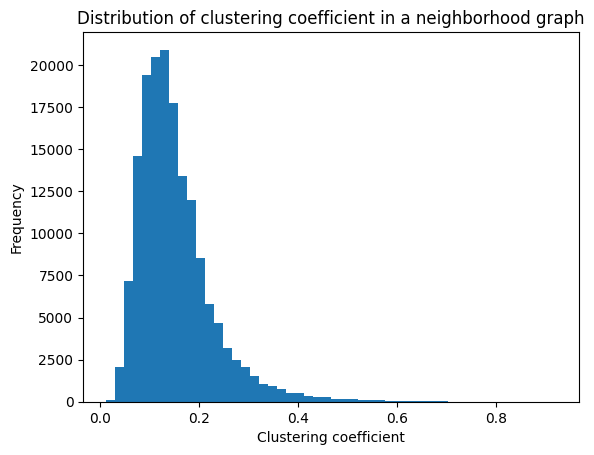

In [13]:
# Plot the distribution of clustering coefficients
import matplotlib.pyplot as plt
coefs = list(clustering_coeff.values())
plt.title('Distribution of clustering coefficient in a neighborhood graph')
plt.hist(coefs, bins=50)
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.show()


## Heatmap of clustering coefficient

In [16]:
adata.obs['clus_coeff_original'] = clustering_coeff.values()

In [17]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,clus_coeff_binary,clus_coeff_original
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4,0.131579,0.131579
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2,0.132353,0.132353
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,0.175824,0.175824
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3,0.104762,0.104762
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5,0.110526,0.110526


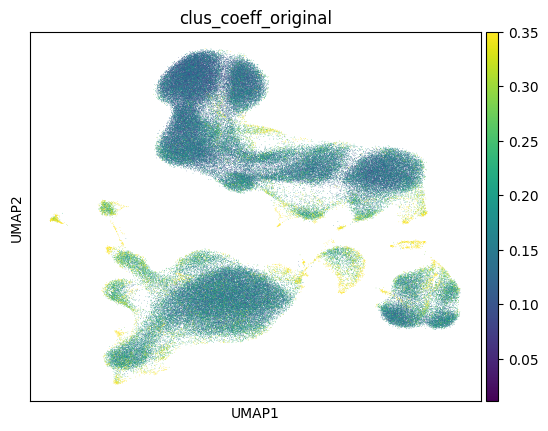

In [18]:
sc.pl.umap(adata, color='clus_coeff_original', vmax=0.35)